<a href="https://colab.research.google.com/github/akeren/beverage-detection/blob/main/Beverage_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CPU Utilisation

In [6]:
!nvidia-smi

Mon May 12 02:49:44 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   35C    P8              9W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

# Python Version

In [7]:
!python --version

Python 3.11.12


# Install all the required packages

In [8]:
!pip install roboflow ultralytics torch torchvision transformers

# Import all the libraries to be used

In [9]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
import logging

from roboflow import Roboflow
from google.colab import userdata
from ultralytics import YOLO
from transformers import DetrForObjectDetection, DetrImageProcessor
from torchvision import transforms
from torchvision.ops import nms
from PIL import Image, ImageDraw
from typing import Tuple, Dict, Any, Optional
from abc import ABC, abstractmethod


# Dataset Downloader Class Definition

In [10]:
class DatasetDownloader(ABC):
    @abstractmethod
    def download(self) -> dict:
        """Download the dataset and return dataset information"""
        pass

class RoboflowConfig:
    def __init__(self, api_key: str):
        if not api_key:
            raise ValueError('API key is missing. Please provide an API Key!')
        self.api_key = api_key
        self.workspace_name = 'roboflow-universe-projects'
        self.project_name = 'beverage-containers-3atxb'
        self.version_number = 3
        self.framework = 'yolov11'

class RoboflowDownloader(DatasetDownloader):
    def __init__(self, config: RoboflowConfig):
        self.config = config
        self.rf = None
        self.project = None
        self.version = None
        self._initialize()

    def _initialize(self):
        """Initialize Roboflow connection and project"""
        self.rf = Roboflow(api_key=self.config.api_key)
        self.project = self.rf.workspace(self.config.workspace_name).project(self.config.project_name)
        self.version = self.project.version(self.config.version_number)

    def download(self) -> dict:
        """Download the dataset using the specified framework"""
        dataset = self.version.download(self.config.framework)
        return dataset

class DatasetFactory:
    @staticmethod
    def create_roboflow_downloader(api_key: Optional[str] = None) -> RoboflowDownloader:
        """
        Factory method to create a RoboflowDownloader instance
        If api_key is not provided, attempts to get it from userdata
        """
        if api_key is None:
            api_key = userdata.get('ROBO_FLOW_API_KEY')

        config = RoboflowConfig(api_key)
        return RoboflowDownloader(config)

# Download Beverage Dataset from Roboflow

In [11]:
def download_dataset():
    try:
        downloader = DatasetFactory.create_roboflow_downloader()
        dataset = downloader.download()

        return dataset
    except ValueError as e:
        print(f"Error occurred: {e}")
        return None

if __name__ == "__main__":
    dataset = download_dataset()

loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to Beverage-Containers-3 in yolov11:: 100%|██████████| 31302/31302 [00:07<00:00, 4158.87it/s]


# Define the Dataset path

In [12]:
data_path = '/content/Beverage-Containers-3/data.yaml'

# Visualise dataset

Class counts:
bottle-glass: 3017
bottle-plastic: 2473
cup-disposable: 2464
cup-handle: 2825
glass-mug: 2775
glass-normal: 2646
glass-wine: 2332
gym-bottle: 2609
tin-can: 2203


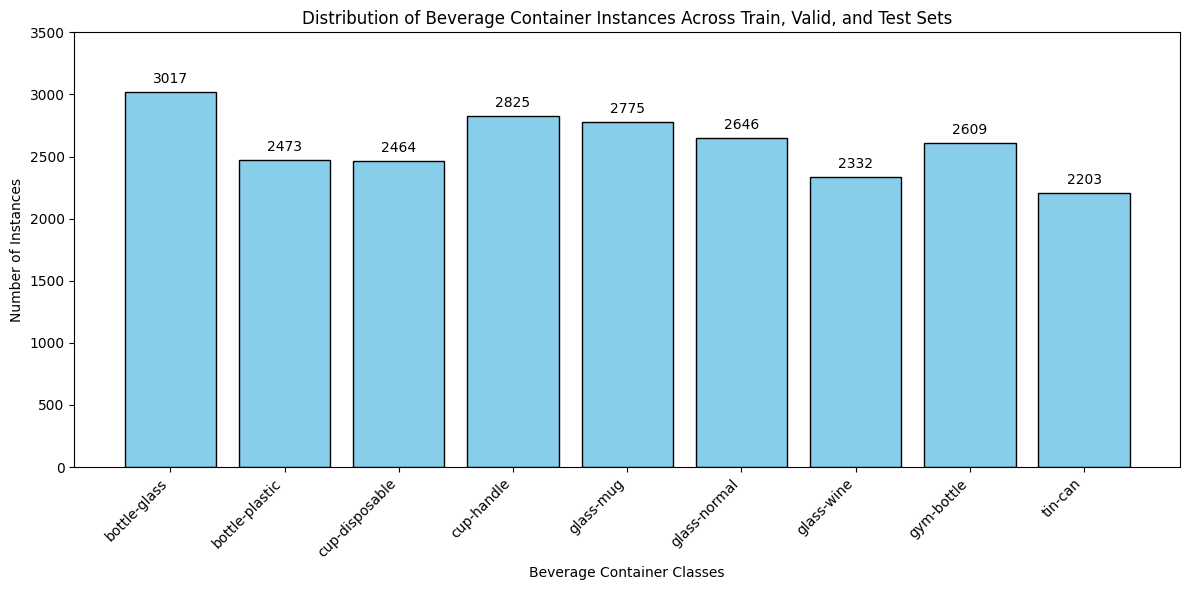

In [13]:
# Class names (consistent formatting)
classes = [
    'bottle-glass', 'bottle-plastic', 'cup-disposable', 'cup-handle',
    'glass-mug', 'glass-normal', 'glass-wine', 'gym-bottle', 'tin-can'
]

# Paths to label directories
label_dirs = [
    '/content/Beverage-Containers-3/train/labels',
    '/content/Beverage-Containers-3/valid/labels',
    '/content/Beverage-Containers-3/test/labels'
]

# Initialize class counts
class_counts = [0] * len(classes)

# Function to count class instances in a directory
def count_classes_in_dir(label_dir):
    if not os.path.exists(label_dir):
        print(f"Directory {label_dir} does not exist.")
        return

    for label_file in os.listdir(label_dir):
        if not label_file.endswith('.txt'):
            continue
        file_path = os.path.join(label_dir, label_file)
        try:
            with open(file_path, 'r') as f:
                for line in f:
                    parts = line.strip().split()
                    if parts:
                        class_id = int(parts[0])
                        if 0 <= class_id < len(classes):
                            class_counts[class_id] += 1
        except Exception as e:
            print(f"Error reading {file_path}: {e}")

# Count classes across all directories
for label_dir in label_dirs:
    count_classes_in_dir(label_dir)

# Print class counts for verification
print("Class counts:")
for class_name, count in zip(classes, class_counts):
    print(f"{class_name}: {count}")

# Create histogram
plt.figure(figsize=(12, 6))
bars = plt.bar(classes, class_counts, color='skyblue', edgecolor='black')
plt.xlabel('Beverage Container Classes')
plt.ylabel('Number of Instances')
plt.title('Distribution of Beverage Container Instances Across Train, Valid, and Test Sets')
plt.xticks(rotation=45, ha='right')
plt.ylim(0, 3500)  # Extend y-axis for clarity

# Add count labels on bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 50, int(height), ha='center', va='bottom')
plt.tight_layout()

# Save plot
plt.savefig('class_distribution_histogram.png')

# Show plot
plt.show()

# Model Training Class Definition

In [14]:
class ModelTrainer:
    class Builder:
        def __init__(self, model):
            self.model = model
            self.data_path = None
            self.epochs = 100
            self.image_size = 640
            self.batch_size = 32
            self.learning_rate = 0.001
            self.optimizer = 'AdamW'
            self.weight_decay = 0.005
            self.patience = 20
            self.augment = True
            self.validate = True
            self.pretrained = True
            self.save = True
            self.resume = True
            self.cosine_learning_rate = True
            self.final_learning_rate = 0.0001

        def set_data_path(self, data_path):
            self.data_path = data_path
            return self

        def set_epochs(self, epochs):
            self.epochs = epochs
            return self

        def set_image_size(self, image_size):
            self.image_size = image_size
            return self

        def set_batch_size(self, batch_size):
            self.batch_size = batch_size
            return self

        def set_learning_rate(self, learning_rate):
            self.learning_rate = learning_rate
            return self

        def set_optimizer(self, optimizer):
            self.optimizer = optimizer
            return self

        def set_weight_decay(self, weight_decay):
            self.weight_decay = weight_decay
            return self

        def set_augment(self, augment):
            self.augment = augment
            return self

        def set_validate(self, validate):
            self.validate = validate
            return self

        def set_patience(self, patience):
            self.patience = patience
            return self

        def set_pretrained(self, pretrained):
            self.pretrained = pretrained
            return self

        def set_save(self, save):
            self.save = save
            return self

        def set_resume(self, resume):
            self.resume = resume
            return self

        def set_cosine_learning_rate(self, cosine_learning_rate):
            self.cosine_learning_rate = cosine_learning_rate
            return self

        def set_final_learning_rate(self, final_learning_rate):
            self.final_learning_rate = final_learning_rate
            return self

        def build(self):
            if self.data_path is None:
                raise ValueError("Data path must be specified")
            return ModelTrainer(self)

    def __init__(self, builder):
        self.model = builder.model
        self.data_path = builder.data_path
        self.epochs = builder.epochs
        self.image_size = builder.image_size
        self.batch_size = builder.batch_size
        self.learning_rate = builder.learning_rate
        self.optimizer = builder.optimizer
        self.weight_decay = builder.weight_decay
        self.augment = builder.augment
        self.validate = builder.validate
        self.patience = builder.patience
        self.pretrained = builder.pretrained
        self.save = builder.save
        self.resume = builder.resume
        self.cosine_learning_rate = builder.cosine_learning_rate
        self.final_learning_rate = builder.final_learning_rate

    def train(self):
        results = self.model.train(
            data=self.data_path,
            epochs=self.epochs,
            imgsz=self.image_size,
            batch=self.batch_size,
            lr0=self.learning_rate,
            lrf=self.final_learning_rate,
            cos_lr=self.cosine_learning_rate,
            optimizer=self.optimizer,
            weight_decay=self.weight_decay,
            augment=self.augment,
            val=self.validate,
            patience=self.patience,
            pretrained=self.pretrained,
            save=self.save,
            resume=self.resume
        )
        return results

# Define Train Model Function

In [15]:
def train_model(model, data_path):
  try:

    trainer = (ModelTrainer.Builder(model)
    .set_data_path(data_path)
    .set_batch_size(16)
    .set_epochs(5)
    .set_patience(5)
    .set_resume(False)
    .build())

    return trainer.train()

  except Exception as e:

    print(f"An error occurred during model training: {e}")

    return None

# YOLOv11 Model Initialisation

In [16]:
model = YOLO('yolo11n.pt')

100%|██████████| 5.35M/5.35M [00:00<00:00, 96.4MB/s]


# Commence Model Training

In [ ]:

model_training_result = train_model(model, data_path)

Ultralytics 8.3.131 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=True, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=True, cutmix=0.0, data=/content/Beverage-Containers-3/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.001, lrf=0.0001, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo11n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train, nbs=64, nms=False, opset=None, optimize=False, optimizer=AdamW, overlap_mask=True, patience=5, perspective=0.0, plots=True, pose=12.0,

100%|██████████| 755k/755k [00:00<00:00, 19.5MB/s]

Overriding model.yaml nc=80 with nc=9

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      6640  ultralytics.nn.modules.block.C3k2            [32, 64, 1, False, 0.25]      
  3                  -1  1     36992  ultralytics.nn.modules.conv.Conv             [64, 64, 3, 2]                
  4                  -1  1     26080  ultralytics.nn.modules.block.C3k2            [64, 128, 1, False, 0.25]     
  5                  -1  1    147712  ultralytics.nn.modules.conv.Conv             [128, 128, 3, 2]              
  6                  -1  1     87040  ultralytics.nn.modules.block.C3k2            [128, 128, 1, True]           
  7                  -1  1    295424  ultralytics

 12             [-1, 6]  1         0  ultralytics.nn.modules.conv.Concat           [1]                           
 13                  -1  1    111296  ultralytics.nn.modules.block.C3k2            [384, 128, 1, False]          
 14                  -1  1         0  torch.nn.modules.upsampling.Upsample         [None, 2, 'nearest']          
 15             [-1, 4]  1         0  ultralytics.nn.modules.conv.Concat           [1]                           
 16                  -1  1     32096  ultralytics.nn.modules.block.C3k2            [256, 64, 1, False]           
 17                  -1  1     36992  ultralytics.nn.modules.conv.Conv             [64, 64, 3, 2]                
 18            [-1, 13]  1         0  ultralytics.nn.modules.conv.Concat           [1]                           
 19                  -1  1     86720  ultralytics.nn.modules.block.C3k2            [192, 128, 1, False]          
 20                  -1  1    147712  ultralytics.nn.modules.conv.Conv             [128,

train: Scanning /content/Beverage-Containers-3/train/labels... 3783 images, 0 backgrounds, 0 corrupt:  28%|██▊       | 3783/13689 [00:02<00:07, 1385.21it/s]

# Load a pre-trained DETR model for fine-grained classification

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
detr_processor = DetrImageProcessor.from_pretrained("facebook/detr-resnet-50")
detr_model = DetrForObjectDetection.from_pretrained("facebook/detr-resnet-50").to(device)
detr_model.eval()

# Output of Model Training, Testing, and Validation

In [ ]:
from IPython.display import display, Image

# Labels

In [ ]:
Image(filename=f'/content/runs/detect/train/labels.jpg', width=1000)

# Label Correlogram

In [ ]:
Image(filename=f'/content/runs/detect/train/labels_correlogram.jpg', width=1000)

# Results

In [ ]:
Image(filename=f'/content/runs/detect/train/results.png', width=1000)

# Precision-Recall Curve

In [ ]:
Image(filename=f'/content/runs/detect/train/PR_curve.png', width=1000)

# Precision-Confidence Curve

In [ ]:
Image(filename=f'/content/runs/detect/train/P_curve.png', width=1000)

# Recall-Confidence Curve

In [ ]:
Image(filename=f'/content/runs/detect/train/R_curve.png', width=1000)

# F1 Confidence

In [ ]:
Image(filename=f'/content/runs/detect/train/F1_curve.png', width=1000)

# Confusion Matrix

In [ ]:
Image(filename=f'/content/runs/detect/train/confusion_matrix.png', width=1000)

# Normalised Confusion Matrix

In [ ]:
Image(filename=f'/content/runs/detect/train/confusion_matrix_normalized.png', width=1000)

In [ ]:
userdata.get('HF_TOKEN')

detr_processor = DetrImageProcessor.from_pretrained("facebook/detr-resnet-50")
detr_model = DetrForObjectDetection.from_pretrained("facebook/detr-resnet-50")

# Monte Carlo Dropout for Uncertainty Estimation

In [ ]:
class MonteCarloPredictor(ABC):
    """Abstract base class defining the Monte Carlo prediction template"""

    def __init__(self, model: Any, n_samples: int = 5):
        self.model = model
        self.n_samples = n_samples

    def predict_with_uncertainty(self, inputs: Dict[str, Any]) -> Tuple[
        torch.Tensor, torch.Tensor, torch.Tensor, torch.Tensor
    ]:
        """Template method defining the prediction algorithm"""
        # Step 1: Prepare model
        self._prepare_model()

        # Step 2: Collect samples
        samples = self._collect_samples(inputs)

        # Step 3: Restore model state
        self._restore_model()

        # Step 4: Process samples
        return self._process_samples(samples)

    @abstractmethod
    def _prepare_model(self) -> None:
        """Prepare the model for sampling"""
        pass

    @abstractmethod
    def _restore_model(self) -> None:
        """Restore the model to its default state"""
        pass

    @abstractmethod
    def _collect_samples(self, inputs: Dict[str, Any]) -> Dict[str, torch.Tensor]:
        """Collect Monte Carlo samples"""
        pass

    @abstractmethod
    def _process_samples(self, samples: Dict[str, torch.Tensor]) -> Tuple[
        torch.Tensor, torch.Tensor, torch.Tensor, torch.Tensor
    ]:
        """Process collected samples to compute means and uncertainties"""
        pass

class DropoutPredictor(MonteCarloPredictor):
    """Concrete implementation for dropout-based Monte Carlo prediction"""

    def _prepare_model(self) -> None:
        self.model.train()  # Enable dropout

    def _restore_model(self) -> None:
        self.model.eval()  # Disable dropout

    def _collect_samples(self, inputs: Dict[str, Any]) -> Dict[str, torch.Tensor]:
        all_logits = []
        all_boxes = []

        for _ in range(self.n_samples):
            with torch.no_grad():
                outputs = self.model(**inputs)
                all_logits.append(outputs.logits)
                all_boxes.append(outputs.pred_boxes)

        return {
            'logits': torch.stack(all_logits),
            'boxes': torch.stack(all_boxes)
        }

    def _process_samples(self, samples: Dict[str, torch.Tensor]) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor, torch.Tensor]:
        def convert_detr_boxes(boxes):
            x_center, y_center, w, h = boxes.unbind(-1)
            x_min = x_center - w / 2
            y_min = y_center - h / 2
            x_max = x_center + w / 2
            y_max = y_center + h / 2
            return torch.stack([x_min, y_min, x_max, y_max], dim=-1)

        logit_mean = torch.mean(samples['logits'], dim=0)
        logit_std = torch.std(samples['logits'], dim=0)
        logit_uncertainty = torch.mean(logit_std, dim=-1)

        box_mean = convert_detr_boxes(torch.mean(samples['boxes'], dim=0))
        box_std = torch.std(samples['boxes'], dim=0)
        box_uncertainty = torch.mean(box_std, dim=-1)

        return logit_mean, logit_uncertainty, box_mean, box_uncertainty


def get_predictions(model, inputs, n_samples: int = 5) -> tuple:

    predictor = DropoutPredictor(model, n_samples=n_samples)
    results = predictor.predict_with_uncertainty(inputs)

    logit_mean, logit_uncertainty, box_mean, box_uncertainty = results

    return logit_mean, logit_uncertainty, box_mean, box_uncertainty

# Calculate Vectorised Intersection over Union (IoU) of two bounding boxes.

In [ ]:
def calculate_iou_vectorized(bbox1, bbox2):
    bbox2 = bbox2.to(bbox1.device)
    x1 = torch.maximum(bbox1[:, None, 0], bbox2[None, :, 0])
    y1 = torch.maximum(bbox1[:, None, 1], bbox2[None, :, 1])
    x2 = torch.minimum(bbox1[:, None, 2], bbox2[None, :, 2])
    y2 = torch.minimum(bbox1[:, None, 3], bbox2[None, :, 3])
    intersection = torch.clamp(x2 - x1, min=0) * torch.clamp(y2 - y1, min=0)
    area1 = (bbox1[:, 2] - bbox1[:, 0]) * (bbox1[:, 3] - bbox1[:, 1])
    area2 = (bbox2[:, 2] - bbox2[:, 0]) * (bbox2[:, 3] - bbox2[:, 1])
    union = area1[:, None] + area2[None, :] - intersection
    iou = intersection / union.clamp(min=1e-6)

    print('IOU:', iou)

    return iou

# Visualise output

In [ ]:
def fix_box_coordinates(box):
    x_min, y_min, x_max, y_max = box
    if x_min > x_max:
        x_min, x_max = x_max, x_min
    if y_min > y_max:
        y_min, y_max = y_max, y_min
    return [x_min, y_min, x_max, y_max]

def visualize_boxes(image_path, yolo_boxes, detr_boxes, iou_matrix, max_iou, detr_indices):
    if os.path.isfile(image_path):
        image = Image.open(image_path).convert('RGB')
        draw = ImageDraw.Draw(image)
        img_w, img_h = image.size

        for i, box in enumerate(yolo_boxes):
            box = box.cpu().numpy().tolist()
            box = fix_box_coordinates(box)
            draw.rectangle(box, outline='red', width=2)

            if max_iou[i] > 0.1:
                j = detr_indices[i]
                detr_box = (detr_boxes[j].cpu().numpy() * [img_w, img_h, img_w, img_h]).tolist()
                detr_box = fix_box_coordinates(detr_box)
                draw.rectangle(detr_box, outline='blue', width=2)

        image.save("hybrid_result.png")
        print("Saved visualization to hybrid_result.png")
    else:
        print(f"Error: Invalid image path: {image_path}")

# Hybrid Detection with Uncertainty, YOLOv11 and DETR outputs

In [ ]:
def hybrid_detection(image_paths, confidence_threshold=0.5, iou_threshold=0.5, uncertainty_threshold=0.1, n_samples_mc=5):
    if isinstance(image_paths, str):
        image_paths = [image_paths]
    images = [Image.open(p).convert('RGB') for p in image_paths]
    resized_images = [img.resize(((img.width // 32) * 32, (img.height // 32) * 32)) for img in images]
    image_tensors = torch.stack([transforms.ToTensor()(img) for img in resized_images])

    yolo_results = model(image_tensors)
    batch_results = []

    for idx, (image, yolo_result) in enumerate(zip(images, yolo_results)):
        yolo_boxes = yolo_result.boxes.xyxy
        yolo_confidences = yolo_result.boxes.conf
        yolo_classes = yolo_result.boxes.cls
        print(f"Image {idx}: YOLO Confidences:", yolo_confidences)

        keep = yolo_confidences > confidence_threshold
        if not keep.any():
            print(f"Image {idx}: No YOLO detections above threshold {confidence_threshold}")
            batch_results.append(None)
            continue
        yolo_boxes = yolo_boxes[keep]
        yolo_confidences = yolo_confidences[keep]
        yolo_classes = yolo_classes[keep]

        # Apply NMS to remove duplicates
        nms_indices = nms(yolo_boxes, yolo_confidences, iou_threshold=0.5)
        yolo_boxes = yolo_boxes[nms_indices]
        yolo_confidences = yolo_confidences[nms_indices]
        yolo_classes = yolo_classes[nms_indices]
        print(f"Image {idx}: After NMS - Boxes:", yolo_boxes, "Confidences:", yolo_confidences)


        img_w, img_h = resized_images[idx].size
        yolo_boxes_normalized = yolo_boxes / torch.tensor([img_w, img_h, img_w, img_h], device=yolo_boxes.device)
        print(f"Image {idx}: Normalized YOLO Boxes:", yolo_boxes_normalized)

        inputs = detr_processor(images=image, return_tensors="pt")
        logit_mean, logit_uncertainty, box_mean, box_uncertainty = get_predictions(detr_model, inputs, n_samples_mc)
        print(f"Image {idx}: DETR Boxes:", box_mean[0])

        detr_conf = torch.softmax(logit_mean[0, :, :-1], dim=-1).max(dim=-1)[0]
        detr_keep = detr_conf > 0.2
        if detr_keep.sum() == 0:
            print(f"Image {idx}: No DETR detections above confidence 0.2")
            refined_results = [{
                "yolo_box": yolo_boxes[i].tolist(),
                "yolo_confidence": yolo_confidences[i].item(),
                "yolo_class": yolo_classes[i].item(),
                "detr_box": None,
                "detr_confidence": None,
                "combined_confidence": yolo_confidences[i].item(),
                "logit_uncertainty": None,
                "box_uncertainty": None
            } for i in range(len(yolo_boxes))]
            batch_results.append(refined_results)
            continue

        box_mean_filtered = box_mean[0][detr_keep]
        box_mean_filtered_fixed = torch.tensor([fix_box_coordinates(box.cpu().numpy()) for box in box_mean_filtered], device=box_mean_filtered.device)
        logit_uncertainty_filtered = logit_uncertainty[0][detr_keep]
        box_uncertainty_filtered = box_uncertainty[0][detr_keep]
        detr_conf_filtered = detr_conf[detr_keep]

        iou_matrix = calculate_iou_vectorized(yolo_boxes_normalized, box_mean_filtered_fixed)
        max_iou, detr_indices = iou_matrix.max(dim=1)
        valid_matches = max_iou > iou_threshold
        print(f"Image {idx}: Max IoU:", max_iou)

        visualize_boxes(image_paths[idx], yolo_boxes, box_mean[0], iou_matrix, max_iou, detr_indices)

        refined_results = []
        # Iterate over all YOLO detections, not just valid matches
        for i in range(len(yolo_boxes)):
            if i < len(valid_matches) and valid_matches[i]:
                j = detr_indices[i]
                detr_box = box_mean_filtered_fixed[j].cpu().numpy()
                l_uncert = logit_uncertainty_filtered[j].item()
                b_uncert = box_uncertainty_filtered[j].item()
                detr_conf = detr_conf_filtered[j].item()
                print(f"Image {idx}: DETR Match {i} - Confidence: {detr_conf}, Uncertainty - Logit: {l_uncert}, Box: {b_uncert}")

                w_yolo = 1 / (b_uncert + 1e-6)
                w_detr = 1 / (l_uncert + 1e-6)
                combined_conf = (yolo_confidences[i].item() * w_yolo + detr_conf * w_detr) / (w_yolo + w_detr)

                if l_uncert < uncertainty_threshold and b_uncert < uncertainty_threshold:
                    refined_results.append({
                        "yolo_box": yolo_boxes[i].tolist(),
                        "yolo_confidence": yolo_confidences[i].item(),
                        "yolo_class": yolo_classes[i].item(),
                        "detr_box": detr_box.tolist(),
                        "detr_confidence": detr_conf,
                        "combined_confidence": combined_conf,
                        "logit_uncertainty": l_uncert,
                        "box_uncertainty": b_uncert
                    })
                else:
                    print(f"Image {idx}: DETR Match {i} excluded due to high uncertainty (Logit: {l_uncert}, Box: {b_uncert})")
                    refined_results.append({
                        "yolo_box": yolo_boxes[i].tolist(),
                        "yolo_confidence": yolo_confidences[i].item(),
                        "yolo_class": yolo_classes[i].item(),
                        "detr_box": None,
                        "detr_confidence": None,
                        "combined_confidence": yolo_confidences[i].item(),
                        "logit_uncertainty": None,
                        "box_uncertainty": None
                    })
            else:
                refined_results.append({
                    "yolo_box": yolo_boxes[i].tolist(),
                    "yolo_confidence": yolo_confidences[i].item(),
                    "yolo_class": yolo_classes[i].item(),
                    "detr_box": None,
                    "detr_confidence": None,
                    "combined_confidence": yolo_confidences[i].item(),
                    "logit_uncertainty": None,
                    "box_uncertainty": None
                })

        batch_results.append(refined_results if refined_results else None)

    return batch_results if len(batch_results) > 1 else batch_results[0]

# Test Hybrid approach

In [ ]:
def test_hybrid_approach(image_paths, confidence_threshold=0.10, iou_threshold=0.1, uncertainty_threshold=0.7, n_samples_mc=20):
    results = hybrid_detection(image_paths, confidence_threshold, iou_threshold, uncertainty_threshold, n_samples_mc)

    if isinstance(image_paths, str):  # Single image
        if results is None:
            print("No high-confidence detections.")
            return
        print("Hybrid Detection Results:")
        for res in results:
            print(res)
    else:  # Batch of images
        for i, res in enumerate(results):
            print(f"Image {i + 1} Results:")
            if res is None:
                print("No high-confidence detections.")
            else:
                for r in res:
                    print(r)

# Testing Model

In [ ]:
# Example Usage
image_path = "/content/IMG_3740.JPG"
test_hybrid_approach(image_path)

# # Batch Example
# image_paths = ["/content/path/to/image1.jpg", "/content/path/to/image2.jpg"]
# test_hybrid_approach(image_paths)